# Figure 1 of GW190521 discovery paper

This notebook generates Figure 1 of   
__GW190521: A Binary Black Hole Merger with a Total Mass of 150 Msun__ avaliable
through [PRL](), [arXiv](https://arxiv.org/abs/2008.xxxx), and [LIGO-P2000020](https://dcc.ligo.org/LIGO-P2000020/public).  

The data used in this notebook is in GW190521_discovery_Fig1.tgz in the public LIGO DCC page [LIGO-P2000158](https://dcc.ligo.org/P2000158/public).


# Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# matplotlib params for pub-quality plots
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
matplotlib.rcParams['legend.fontsize'] = 9

# LIGO-specific software:
from gwpy.timeseries import TimeSeries   # https://gwpy.github.io/

# Configuration
Frequency, time ranges etc

In [2]:
event = "GW190521"
trigtime=1242442967.447
f_range=(9, 400)
q_range=(6,6)
searchwin=0.1
outseg=(-4+trigtime,4+trigtime)
delta_t=1./1024
times = np.arange(outseg[0],outseg[1],delta_t)

dets=["H1","L1","V1"]
det_names = ['Hanford','Livingston','Virgo']

# Read in the data files


In [3]:
white_data = [np.genfromtxt("./whitened_data_{}.dat".format(det)) for det in dets]
LI_data    = [np.genfromtxt("./{}_summary_waveforms_samples.dat".format(det), names=True) for det in dets]
BW_data    = [np.genfromtxt("./signal_median_time_domain_waveform_{}.dat".format(det)) for det in dets]
cwb_data   = [np.genfromtxt("./{}_pewave_cr.txt".format(det), names=True) for det in dets]

# Low-pass filter the whitened data

In [4]:
import scipy.signal as sig

sample_rate = 1024.0
nsamples = 4096
t = np.arange(nsamples) / sample_rate
nyq_rate = sample_rate / 2.0
width = 8.0/nyq_rate
ripple_db = 10
N, beta = sig.kaiserord(ripple_db, width)
cutoff_hz = 128

# low pass filter the data
taps = sig.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
temp = [sig.lfilter(taps, 1.0, x) for x in white_data]
temp = [np.flipud(x) for x in temp]
temp = [sig.lfilter(taps, 1.0, x) for x in temp]
low_pass_data = [np.flipud(x) for x in temp]

# Create TimeSeries and other Conditioned Objects  

In [5]:
white_data = [TimeSeries(data=wd, dt=delta_t, t0=times[0]) for w,wd in enumerate(white_data)]
low_pass_data = [TimeSeries(data=wd, dt=delta_t, t0=times[0]) for w,wd in enumerate(low_pass_data)]

# LALInference (LI) intervals 
li_intervals = []
for i, det in enumerate(dets):
    li_intervals.append([ LI_data[i][bound] 
                         for b,bound in enumerate(
                             ["whitened_lower_bound_90", "whitened_ML", "whitened_upper_bound_90"])
                        ])
    
# bayeswave intervals file: Time | median | lower50 | upp50 | lower90 | upp90
bw_intervals =[]
for i, det in enumerate(dets):
    bw_intervals.append( [ BW_data[i][:,b] for b in [ 4, 5] ])

## Q-scans
Use gwpy to create Q-scans of the BayesLine-whitened timeseries dumped from the BayesWave analysis of this data.

In [6]:
print("Making white-noisy Q-scans")

# warnings from qtransform are ignorable
import warnings
warnings.simplefilter('ignore', category=UserWarning)

qscans_white_noisy = [wd.q_transform(frange=f_range, qrange=q_range, 
                         outseg=outseg, whiten=False) for wd in white_data]

qtimes = qscans_white_noisy[0].xindex.value
qfreqs = qscans_white_noisy[0].yindex.value
print(qfreqs)

Making white-noisy Q-scans
[  9.    9.5  10.  ... 328.5 329.  329.5]


# Results Plots

The big plot is a set of panels with H, L and V in each column.
 * Row 1: Whitened time-series, with three different waveform reconstructions (BW, LI, CWB) superimposed 
 * Row 2: Q-scans

on row  0
on row  1
Making Qscans
Making Qscans
Making Qscans


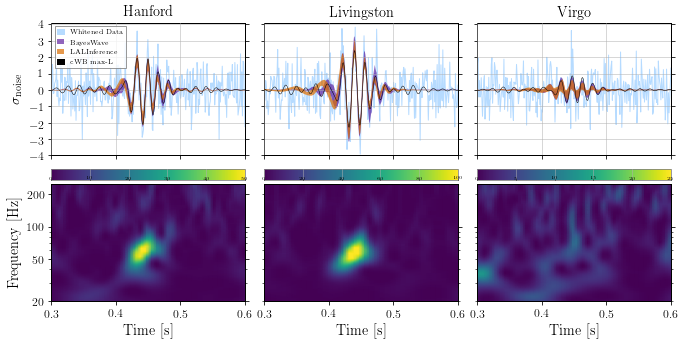

Saving
Done


<Figure size 432x288 with 0 Axes>

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# colorblind-friendly colors
cb_friendly_list = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

li_color=cb_friendly_list[12]
bw_color=cb_friendly_list[5]
cwb_color=cb_friendly_list[0]
nanosecond=np.mod(1242442967.44726562,1)
origin=1242442967 #(Ratio to multiply the "strain" data with so that it's units of single digit numbers)

fbig, axbig = plt.subplots(figsize=(6.75*1.5, 3*1.5), ncols=3, nrows=2)
amp_maxes = [50, 100, 25]

for row in range(2):
    print("on row ", row)
    for col, det in enumerate(dets):
        
        
        # SNR series
        if row==0:
            axbig[row][col].set_ylim(-4, 4.1)
            axbig[row][col].set_yticks(np.arange(-4, 4.1, 1.0))

            wd = axbig[row][col].plot(np.array(white_data[col].xindex)-origin, white_data[col], 
                                      color=cb_friendly_list[9], alpha=1.0, linewidth=1.0, zorder=1)
            axbig[row][col].tick_params(
                            axis='x',          # changes apply to the x-axis
                            which='major',      # both major and minor ticks are affected
                            bottom=True,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            labeltop=False,
                            labelbottom=False,
                            direction="out")
            
            axbig[row][col].fill_between(np.array(white_data[col].xindex)-origin, bw_intervals[col][0],
                         bw_intervals[col][1], alpha=0.6, zorder=2, color=bw_color, lw=0,
                         label=r'$\textrm{Wavelets}$')

            axbig[row][col].fill_between(np.array(white_data[col].xindex)-origin, li_intervals[col][0],
                         li_intervals[col][2], alpha=0.7,
                         zorder=3, color=li_color, lw=0,
                         label=r'$\textrm{BBH}$')
                
            cwbh = axbig[row][col].plot(cwb_data[col]['time']-origin, cwb_data[col]['amp_cwb_rec'],
                                        lw=0.5, color=cwb_color, zorder=4 )
                
                
            if det=='H1':
                axbig[row][col].set_ylabel(r'$\sigma_{\textrm{noise}}$')
                bwh = plt.Rectangle((0, 0), 1, 1, fc=bw_color, alpha=0.6)
                lih = plt.Rectangle((0, 0), 1, 1, fc=li_color, alpha=0.7)
                bwl = r'$\textrm{BayesWave}$'
                lil = r'$\textrm{LALInference}$'
                wdl = r'$\textrm{Whitened Data}$'
                cwbl = r'$\textrm{cWB max-L}$'
                lines = [wd[0], bwh,lih, cwbh[0]]
                labels = [wdl, bwl,lil, cwbl]
                axbig[row][col].legend(lines, labels,loc='upper left', fontsize=7)
                                
        # Qscans
        if row==1:
            Z =  4.0/np.pi*qscans_white_noisy[col].T
            print('Making Qscans')
            pcol=axbig[row][col].pcolormesh(qtimes-origin, qfreqs,Z, 
                                    vmin=0,vmax=amp_maxes[col],
                                    cmap='viridis', shading='gouraud',
                                    rasterized=True)
            axbig[row][col].set_yscale('log')
            axbig[row][col].set_ylim(20, 250)
            divider = make_axes_locatable(axbig[row][col])
            cax = divider.append_axes('top', size='10%', pad=0.05)
            #cax = inset_axes(axbig[row][col], width="3%", height="90%", loc='lower right') 
            fbig.colorbar(pcol, cax=cax, orientation='horizontal')
            #color_ticks = np.arange(0,amp_maxes+1, amp_maxes/10.0)
            cax.tick_params(axis='both', direction="in", labelsize=5, size=1, pad=-4.2)
                            
            if det=='H1': 
                axbig[row][col].set_ylabel(r'$\textrm{Frequency~[Hz]}$')
                axbig[row][col].set_yticks(np.array([20, 50, 100, 200]))
                #axbig[row][col].set_yticklabels(np.array([20, 50, 100, 200]))
                                
            axbig[row][col].grid()
                        
            axbig[row][col].set_xlabel(r'$\textrm{Time [s]}$')
            axbig[row][col].tick_params(
                            axis='x',          # changes apply to the x-axis
                            which='major',      # both major and minor ticks are affected
                            bottom=True,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            labeltop=False,
                            labelbottom=True,
                            direction="out")
            
        if det=='H1':
            axbig[row][col].tick_params(
                            axis='y',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            left=True,      # ticks along the bottom edge are off
                            right=True,         # ticks along the top edge are off
                            labelleft=True,
                            labelright=False,
                            direction="out")
        if not det=='H1':
            axbig[row][col].set_yticklabels([])
            axbig[row][col].tick_params(
                            axis='y',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            left=True,      # ticks along the bottom edge are off
                            right=True,         # ticks along the top edge are off
                            labelleft=False,
                            labelright=False,
                            direction="out")               
        
        axbig[row][col].set_xlim(0.3, 0.6)
        axbig[0][col].set_title(r'$\textrm{%s}$'%det_names[col])
        #axbig[row][col].tick_params(axis="y", direction="out")
        #axbig[row][col].tick_params(axis="x", direction="out")
            
        for axis in ['top','bottom','left','right']:
            axbig[row][col].spines[axis].set_linewidth(1.0)
            axbig[row][col].spines[axis].set_color('k')
                
# Adjust white space here
plt.subplots_adjust(left=0.075, right=0.925, bottom=0.09, top=0.95, 
                    wspace=0.1, hspace=0.1)

plt.show()

print('Saving')
plt.savefig('whitedata_reconstructions_qscan.pdf')
plt.savefig('whitedata_reconstructions_qscan.png')
print('Done')
